# Identificador de personas

### Autor: Jesús Octavio García Flores

El objetivo de este trabajo es recrear un identificador de personas mediante el uso de algoritmos de IA. Se utiliza como base el framework de **Tensorflow** y la idea se ha tomado de este tutorial: [Reconocimiento facial](https://www.youtube.com/watch?v=23z9BijlrTs). Se logró obtener el reconocimiento de personas, pero sólo se logró hacerlo por una a la vez y no es muy preciso. Es decir, si se ejecuta el código, captura el rostro de la persona en ese momento y genera la identificación, pero si se incluye a otra persona en la imagen, ésta no será reconocida y si ya se hizo la identificación de alguien y se cambia la persona con la cámara ejecutándose, mantendrá el nombre de la persona anterior. Para que la segunda persona sea identificada, debe cerrarse la cámara e iniciarla de nuevo ejecutando las líneas de código img_predict() y reconociendo(). La implementación de patrones específicos de reconocimiento facial ayuda muchísimo y no incluirlos en este trabajo merma la precisión.

## ¿Cómo aplicarlo?

### Vamos a utilizar unas herramientas de la biblioteca de [OpenCV](https://docs.opencv.org/master/).
(para intalar ver [Instalar OpenCV](https://docs.opencv.org/master/da/df6/tutorial_py_table_of_contents_setup.html))

Podemos descargar o clonar los archivos desde este [repositorio de github](https://github.com/jorge190588/face_recognitionOpenCv2).

En mi caso descargué el zip y descomprimí el archivo en la carpeta **"Proyecto"**. Copié el archivo llamado **"dataset.py"** que se encuentra en la carpeta descomprimida (**"face_recognitionOpenCv2-master"**) y lo pegué directamente una escala arriba (es decir, en la carpeta del proyecto directamente). Modifiqué el archivo **"dataset.py"** y lo renombré como **"camara.py"** y le hice un par de modificaciones extras:
- El código lo metì en una función: para generar una carpeta con el nombre de la persona a identificar y almacenar las imágenes crrespondientes.
- Modifiqué el path del **"cascPath"** por que usaré el archivo **"haarcascade_frontalface_default.xml"** (de reconocimiento de rostro frontal) que está en **"face_recognitionOpenCv2-master/Cascade"**.
- En el archivo original **"dataset.py"** la ruta para las carpetas de imágenes ya tiene un nombre específico (Eduardo) y cada que se entrena con una persona diferente se debe cambiar manualmete esta ruta, entrando al archivo y escribiendo el nombre de la persona nueva. Aunque no cuesta mucho trabajo, preferí agregar una variable con el nombre para tener el cambio "más a la mano".
- Hice lo mismo para el número de imágenes que tomará la cámara.
- Desafortunadamente, aún se deben anexar manualmente los nombres de las personas a identificar.

Con las característics actuales de este código hay que hacer lo siguiente:

- Vamos a ejecutar celda por celda. Iniciamos por la carga de las librerías.
- Escribe tu nombre en la variable 'name', ejecuta esa celda y la siguiente.
- Manteniendo la vista hacia la cámara de la computadora ejecuta la celda de captura de imágenes y espera a que el sistema cierre la cámara (puedes hacer algunos gestos, como sonreir o muecas, para darle variedad al entrenamiento).
- Ejecuta las siuientes 4 celdas de la Arquitectura de la red de entrenamiento. La cuarta de estas celdas da la información de los nombres (etiquetas) de cada persona almacenada en el directorio de imágenes (se ordenan en orden alfabético). Éstas las usaremos más adelante.
- En la sección de 'Modelo y entrenamiento' corre las primeras 3 celdas y espera a que la red se entrene.
- Terminando el entrenamiento, ejecuta la siguiente celda para guardar el modelo.
- La celda enseguida contiene el algoritmo de predicción que debemos modificar. Haremos uso de las etiquetas asignadas a cada persona (su nombre) que se nos proporcionó con 'train.class_indices'. Respetando el orden proporcionado por 'train.class_indices' vamos a modificar si es necesario los **if**. En principio a 'Elon_Musk' le corresponde la variable cero, a 'Karla' la variable 1, a 'Octavio' 2 y a 'Wolowitz' 3. Si queremos agregar a otra persona entonces repetimos el proceso desde el inicio y utilizamos las etiquetas que 'train.class_indices' nos de. 
- Una vez modificados los **if** del paso anterior, ejecutamos dicha celda y las dos siguientes.
- Finalmente, mirando hacia la cámara nuevamente ejecutamos la última celda (Para cerrar y finalizar la cámara hay que oprimir **q** minúscula).

### Importanto las librerías

In [1]:
import os
import sys
import cv2
import numpy as np
from internal_functions import *

from keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Convolution2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Flatten, Dense, Activation

import matplotlib.image as img
import matplotlib.pyplot as plt

Using TensorFlow backend.
C:\Users\octav\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\octav\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\octav\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\octav\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

### Creamos  las imágenes con el nombre de la persona y el número de imágenes que queremos almacenar (mínimo 250 en este caso).

In [2]:
name= "Octavio"
num_img = 250

In [3]:
# Crea la carpeta con nombre definido en name
filepath_cam = os.path.join(os.getcwd(), 'images\\' + name)
if not os.path.isdir(filepath_cam):
    os.makedirs(filepath_cam) 

# Crea una carpeta para hacer la identificación
filepath_predict = os.path.join(os.getcwd(), 'predict')
if not os.path.isdir(filepath_predict):
    os.makedirs(filepath_predict) 

##### Captura de imágenes

In [4]:
#Con OpenCV hacemos las capturas con la cámara del equipo
if (100 <= num_img <= 500):
    capturas(name, num_img)  # Crea las imágenes (con diferentes tamaños)
else:
    print("El mínimo de imágenes debe ser 200 y el máximo de 500")


## Arquitectura

Voy a entrenar una red para que aprenda a identificar los rostros como si de clasificación de imágenes se tratara. Es decir, no voy a implementar rasgos característicos avanzados como puntos estreatégicos (labios, ojos, pestañas, comisuras...).
- [Clasificar imágenes](https://www.tensorflow.org/tutorials/images/cnn)

In [2]:
#Algoritmo de entrenamiento (training.py)

#Inicializamos los hiperparámetros

K.clear_session()

path_imgs = os.path.join(os.getcwd(), 'images\\')

lr = 0.001
epochs = 100
input_shape = (64, 64, 3)
batch_size = 32
steps = 1000
val_steps = 200
dim_filtro1 = (4, 4)
dim_filtro2 = (3, 3)
dim_pool = (2, 2)
clases = len(os.listdir(path_imgs))

In [3]:
#Prepara las variables para generar las imágenes de entrenamento y prueba
training_data = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=0.4, #Por si llegamos a girar un poco la cabeza
    shear_range=3.5,     #Por si estamos muy lejos
    validation_split=0.1, #20% de imágenes de test
     )

In [4]:
#Genera el conjunto de datos
train = training_data.flow_from_directory(
    path_imgs,
    target_size=(input_shape[0], input_shape[1]),
    class_mode='categorical', 
    batch_size=batch_size
)

Found 752 images belonging to 3 classes.


In [5]:
train.class_indices

{'Elon_Musk': 0, 'Octavio': 1, 'Wolowitz': 2}

### Modelo y entrenamiento (red CNN)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


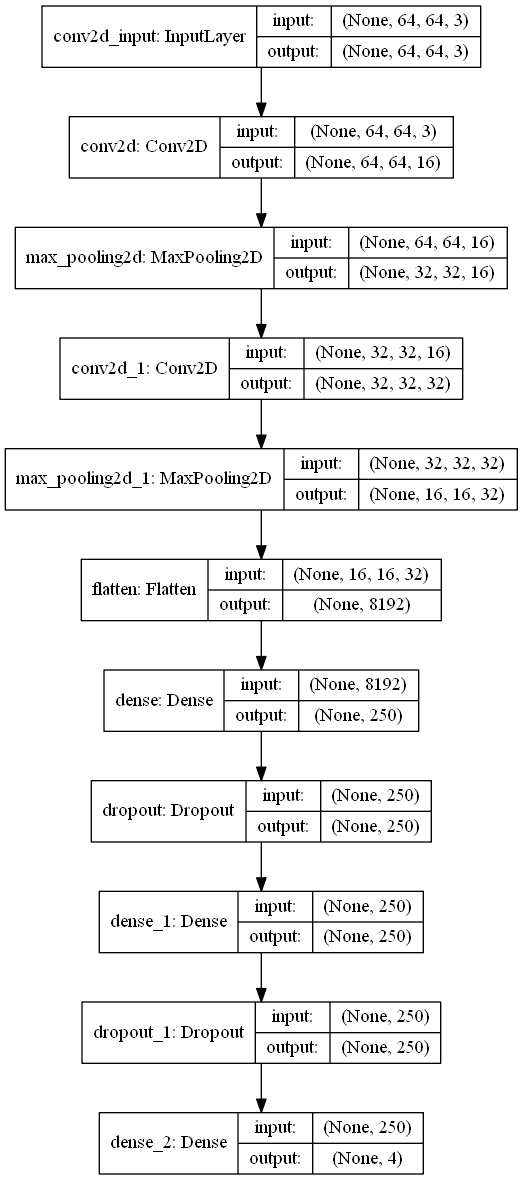

In [9]:
model = Sequential()

#Input layer
model.add(Convolution2D(16, dim_filtro1, padding ="same", input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size = dim_pool))

model.add(Convolution2D(32, dim_filtro2, padding ="same", activation='relu'))
model.add(MaxPooling2D(pool_size=dim_pool))

model.add(Flatten())

model.add(Dense(250, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(250, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(clases, activation='softmax'))


#Compilación
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=lr), metrics=['accuracy'])

#Imagen del modelo
plot_model(model, to_file='model.png', show_shapes=True, rankdir='TB', expand_nested=True, show_layer_names=True, dpi=96)


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        784       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 250)               2048250   
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
__________

In [11]:
#Entrenamiento
model.fit(train, steps_per_epoch=steps, epochs=epochs, validation_steps=val_steps, validation_split=0.1)


Instructions for updating:
Use tf.cast instead.
Epoch 1/100
32/32 [==============================] - 5s 158ms/step - loss: 0.7075 - acc: 0.7009
Epoch 2/100
32/32 [==============================] - 4s 125ms/step - loss: 0.0346 - acc: 0.9880
Epoch 3/100
32/32 [==============================] - 4s 124ms/step - loss: 0.0113 - acc: 0.9970
Epoch 4/100
32/32 [==============================] - 4s 124ms/step - loss: 0.0046 - acc: 1.0000
Epoch 5/100
32/32 [==============================] - 5s 151ms/step - loss: 0.0019 - acc: 1.0000
Epoch 6/100
32/32 [==============================] - 5s 156ms/step - loss: 3.8220e-04 - acc: 1.0000
Epoch 7/100
32/32 [==============================] - 5s 152ms/step - loss: 1.8541e-04 - acc: 1.0000
Epoch 8/100
32/32 [==============================] - 5s 153ms/step - loss: 2.5952e-04 - acc: 1.0000
Epoch 9/100
32/32 [==============================] - 5s 154ms/step - loss: 1.0000e-04 - acc: 1.0000
Epoch 10/100
32/32 [==============================] - 5s 154ms/step - lo

In [12]:
# Genera la carpeta donde guardamos el modelo
filepath_model = os.path.join(os.getcwd(), 'model\\')
if not os.path.isdir(filepath_model):
    os.makedirs(filepath_model)

model.save(os.path.join(filepath_model, 'identif_model.h5'))
model.save_weights(os.path.join(filepath_model, 'identif_weights.h5'))

In [11]:
#Algoritmo para hacer la predicción

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

input_shape = (64, 64, 3)
path_model = './model/identif_model.h5'
path_weights = './model/identif_weights.h5'


#Al modelo que guardamos le cargamos los pesos del entrenamiento
model = load_model(path_model)
model.load_weights(path_weights)

#Generamos la predicción
def prediction(img_name):
    imagen = load_img(img_name, target_size=(input_shape[0], input_shape[1])) #Carga la imagen
    imagen = img_to_array(imagen)  #La convierte en un arreglo
    imagen = np.expand_dims(imagen, axis=0)
    labels = model.predict(imagen)[0]  #Devuelve el vector de clases 
    label_img = np.argmax(labels)
    
    #print(labels)
    #print(label_img)
    
    if label_img == 0:
        label = 'Elon_Musk'
    if label_img == 1:
        label = 'Karla'
    if label_img == 2:
        label = 'Octavio'
    if label_img == 3:
        label = 'Wolowitz'
        
    return label   #Regresa el nombre de la persona (su etiqueta)

Instructions for updating:
Use tf.cast instead.


In [22]:
"""
#Esta celda sirvió como comprobación a la clasificación

dir_name = 'predict'
for image in os.listdir('.\\{}'.format(dir_name)):
    predictions = prediction('.\\{}'.format(dir_name) + '\\' + image)
    print(predictions)
    print('.\\{}'.format(dir_name) + '\\' + image)
""";

Wolowitz
.\predict\predict.jpg


In [12]:
def reconociendo():
    """ Abre la cámara local"""
    
    web_cam = cv2.VideoCapture(0)

    cascPath = "face_recognitionOpenCv2-master/Cascades/haarcascade_frontalface_default.xml"
    faceCascade = cv2.CascadeClassifier(cascPath)
    
    for image in os.listdir('.\\predict'):
        label = prediction('.\\predict'+ '\\' + image)
    
    while(True):
        _, imagen_marco = web_cam.read()

        rostro = faceCascade.detectMultiScale(imagen_marco, 1.5, 5)  #Detecta la cara de las personas
        
        
        for(x,y,w,h) in rostro:  #rectángulos        

            cv2.rectangle(imagen_marco, (x,y), (x+w, y+h), (0,200,0), 4)
            cv2.putText(imagen_marco, label, org=(x-10,y-10), 
                        fontFace=cv2.LINE_AA, fontScale=1, color = (50,200,0), thickness=2)            

            
            cv2.imshow("Identificando", imagen_marco)
    

        if cv2.waitKey(1) & 0xFF == ord('q'):  # Detiene la cámara presionando 'q'
            break


    # Cuando todo está hecho, liberamos la captura
    web_cam.release()
    cv2.destroyAllWindows()

In [14]:
img_predict()
reconociendo()